In [1]:
import os, time, math, pickle, random
from dataclasses import dataclass
from typing import Optional, List, Union, Tuple, Dict

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


In [2]:
# --------- metrics ---------
@torch.no_grad()
def rmse(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    return float(torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item())

@torch.no_grad()
def mae(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    return float(torch.mean(torch.abs(y_true - y_pred)).item())

@torch.no_grad()
def r2(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2) + 1e-12
    return float((1.0 - ss_res / ss_tot).item())

@torch.no_grad()
def accuracy(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    return float((y_true == y_pred).float().mean().item())

def _softmax(logits: torch.Tensor) -> torch.Tensor:
    return torch.softmax(logits, dim=1)

## 1) DecisionTree (PyTorch, CART-подобное)

In [24]:
@dataclass
class _Node:
    is_leaf: bool
    prediction: torch.Tensor              # (1,) for regression or (K,) probs for classification
    feature_idx: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["__class__"] = None
    right: Optional["__class__"] = None

class DecisionTree:
    def __init__(
        self,
        max_depth: int = 10,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: Union[int, float, str, None] = "sqrt",
        n_thresholds: int = 16,
        classification: bool = True,
        random_state: int = 42,
        device: Optional[torch.device] = None,
        classes: torch.Tensor | None = None,
    ):
        self.max_depth = int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.n_thresholds = int(n_thresholds)
        self.classification = bool(classification)
        self.random_state = int(random_state)
        self.device = device if device is not None else DEVICE

        self.root: Optional[_Node] = None
        self.n_features_: Optional[int] = None
        self.n_classes_: Optional[int] = None
        self.classes_: Optional[torch.Tensor] = None

        g = torch.Generator(device="cpu")
        g.manual_seed(self.random_state)
        self._gen = g

        self._fixed_classes = classes

    def _feature_subset(self, d: int) -> torch.Tensor:
        mf = self.max_features
        if mf is None:
            k = d
        elif isinstance(mf, str):
            if mf == "sqrt":
                k = max(1, int(math.sqrt(d)))
            elif mf == "log2":
                k = max(1, int(math.log2(d)))
            else:
                raise ValueError(f"Unknown max_features: {mf}")
        elif isinstance(mf, float):
            k = max(1, int(round(d * mf)))
        else:
            k = int(mf)
            k = max(1, min(k, d))
        perm = torch.randperm(d, generator=self._gen)
        return perm[:k]

    def _leaf_prediction(self, y: torch.Tensor) -> torch.Tensor:
        if self.classification:
            counts = torch.bincount(y, minlength=self.n_classes_).float()
            probs = counts / (counts.sum() + 1e-12)
            return probs
        else:
            return torch.tensor([y.mean().item()], device=self.device, dtype=torch.float32)

    def _impurity(self, y: torch.Tensor) -> torch.Tensor:
        if y.numel() == 0:
            return torch.tensor(0.0, device=self.device)
        if self.classification:
            counts = torch.bincount(y, minlength=self.n_classes_).float()
            p = counts / (counts.sum() + 1e-12)
            return 1.0 - torch.sum(p * p)  # Gini
        else:
            mu = y.mean()
            return torch.mean((y - mu) ** 2)  # MSE

    def _best_split(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[Optional[int], Optional[float], float]:
        n, d = X.shape
        parent_imp = self._impurity(y)
        if float(parent_imp.item()) <= 1e-12:
            return None, None, 0.0

        feats = self._feature_subset(d)
        best_gain = 0.0
        best_f = None
        best_t = None

        for f in feats.tolist():
            col = X[:, f]
            if torch.all(col == col[0]):
                continue

            m = min(self.n_thresholds, n)
            # random thresholds from existing values
            idx = torch.randint(0, n, (m,), generator=self._gen)
            cand = torch.unique(col[idx]).tolist()

            for t in cand:
                left_mask = col <= t
                n_left = int(left_mask.sum().item())
                n_right = n - n_left
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                y_left = y[left_mask]
                y_right = y[~left_mask]
                imp_left = self._impurity(y_left)
                imp_right = self._impurity(y_right)

                child_imp = (n_left / n) * imp_left + (n_right / n) * imp_right
                gain = parent_imp - child_imp
                g = float(gain.item())
                if g > best_gain:
                    best_gain = g
                    best_f = f
                    best_t = float(t)

        return best_f, best_t, best_gain

    def _build(self, X: torch.Tensor, y: torch.Tensor, depth: int) -> _Node:
        node = _Node(is_leaf=True, prediction=self._leaf_prediction(y))

        if depth >= self.max_depth:
            return node
        if y.numel() < self.min_samples_split:
            return node
        if float(self._impurity(y).item()) <= 1e-12:
            return node

        f, t, gain = self._best_split(X, y)
        if f is None or gain <= 1e-12:
            return node

        col = X[:, f]
        left_mask = col <= t
        if int(left_mask.sum().item()) < self.min_samples_leaf:
            return node
        if int((~left_mask).sum().item()) < self.min_samples_leaf:
            return node

        node.is_leaf = False
        node.feature_idx = f
        node.threshold = t
        node.left = self._build(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build(X[~left_mask], y[~left_mask], depth + 1)
        return node

    def fit(self, X, y):
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        y = torch.as_tensor(y, device=self.device)

        self.n_features_ = X.shape[1]

        if self.classification:
            # --- use global classes if provided ---
            if self._fixed_classes is not None:
                classes = torch.as_tensor(self._fixed_classes, device=self.device)
            else:
                classes = torch.unique(y).sort().values

            self.classes_ = classes
            self.n_classes_ = int(classes.numel())

            # --- fast vectorized mapping y -> [0..K-1] (works for CIFAR too) ---
            # classes must be sorted (it is)
            y_idx = torch.searchsorted(classes, y.to(classes.dtype)).to(torch.long)

            self.root = self._build(X, y_idx, depth=0)
        else:
            y_f = y.to(torch.float32)
            self.root = self._build(X, y_f, depth=0)

        return self

    def _predict_one(self, x: torch.Tensor) -> torch.Tensor:
        node = self.root
        while node is not None and not node.is_leaf:
            if x[node.feature_idx] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction

    @torch.no_grad()
    def predict_proba(self, X):
        if not self.classification:
            raise ValueError("predict_proba only for classification=True")
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        probs = torch.stack([self._predict_one(X[i]) for i in range(X.shape[0])], dim=0)
        return probs

    @torch.no_grad()
    def predict(self, X):
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        preds = torch.stack([self._predict_one(X[i]) for i in range(X.shape[0])], dim=0)

        if self.classification:
            idx = torch.argmax(preds, dim=1)
            return self.classes_[idx]
        else:
            return preds[:, 0]

## 2) RandomForest (PyTorch)

In [25]:
class RandomForest:
    def __init__(
        self,
        n_estimators: int = 80,
        max_depth: int = 12,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: Union[int, float, str, None] = "sqrt",
        n_thresholds: int = 16,
        bootstrap: bool = True,
        classification: bool = True,
        random_state: int = 42,
        device: Optional[torch.device] = None,
    ):
        self.n_estimators = int(n_estimators)
        self.max_depth = int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.n_thresholds = int(n_thresholds)
        self.bootstrap = bool(bootstrap)
        self.classification = bool(classification)
        self.random_state = int(random_state)
        self.device = device if device is not None else DEVICE

        self.trees: List[DecisionTree] = []
        self.classes_: Optional[torch.Tensor] = None

        g = torch.Generator(device="cpu")
        g.manual_seed(self.random_state)
        self._gen = g

    def fit(self, X, y, verbose: bool = False, print_every: int = 10):
        X = torch.as_tensor(X, dtype=torch.float32)
        y = torch.as_tensor(y)

        n = X.shape[0]
        self.trees = []

        # --- GLOBAL classes for all trees ---
        if self.classification:
            self.classes_ = torch.unique(y).sort().values.to(self.device)

        if verbose:
            print(f"[RF] n_estimators={self.n_estimators}, n={n}, classes={None if not self.classification else len(self.classes_)}")

        t0 = time.time()
        for i in range(self.n_estimators):
            idx = torch.randint(0, n, (n,), generator=self._gen) if self.bootstrap else torch.arange(n)

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                n_thresholds=self.n_thresholds,
                classification=self.classification,
                random_state=self.random_state + i * 10007,
                device=self.device,
                classes=self.classes_ if self.classification else None,   # <-- KEY
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)

            if verbose and ((i + 1) % print_every == 0 or (i + 1) == self.n_estimators):
                print(f"[RF] trained {i+1}/{self.n_estimators} trees  elapsed={time.time()-t0:.1f}s")

        return self

    @torch.no_grad()
    def predict_proba(self, X):
        if not self.classification:
            raise ValueError("predict_proba only for classification=True")
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        probs = None
        for t in self.trees:
            p = t.predict_proba(X)
            probs = p if probs is None else (probs + p)
        return probs / max(1, len(self.trees))

    @torch.no_grad()
    def predict(self, X):
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        if self.classification:
            probs = self.predict_proba(X)
            idx = torch.argmax(probs, dim=1)
            return self.classes_[idx]
        else:
            preds = torch.stack([t.predict(X) for t in self.trees], dim=0)
            return preds.mean(dim=0)

## 3) GradientBoosting (PyTorch)

In [26]:
class GradientBoosting:
    def __init__(
        self,
        n_estimators: int = 80,
        learning_rate: float = 0.08,
        max_depth: int = 3,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: Union[int, float, str, None] = "sqrt",
        n_thresholds: int = 16,
        classification: bool = True,
        random_state: int = 42,
        device: Optional[torch.device] = None,
    ):
        self.n_estimators = int(n_estimators)
        self.learning_rate = float(learning_rate)
        self.max_depth = int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.n_thresholds = int(n_thresholds)
        self.classification = bool(classification)
        self.random_state = int(random_state)
        self.device = device if device is not None else DEVICE

        self.init_pred_: Optional[torch.Tensor] = None
        self.trees_: List[DecisionTree] = []

        self.classes_: Optional[torch.Tensor] = None
        self.n_classes_: Optional[int] = None
        self.trees_mc_: Optional[List[List[DecisionTree]]] = None

    def fit(self, X, y):
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        y = torch.as_tensor(y, device=self.device)

        self.trees_ = []
        self.trees_mc_ = None

        if not self.classification:
            # regression: squared loss
            y_f = y.to(torch.float32)
            self.init_pred_ = y_f.mean()
            pred = torch.full_like(y_f, self.init_pred_)

            for m in range(self.n_estimators):
                residual = y_f - pred
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    max_features=self.max_features,
                    n_thresholds=self.n_thresholds,
                    classification=False,
                    random_state=self.random_state + m * 10007,
                    device=self.device,
                )
                tree.fit(X, residual)
                pred = pred + self.learning_rate * tree.predict(X)
                self.trees_.append(tree)
            return self

        # multiclass: multinomial (one regression tree per class per iter)
        classes = torch.unique(y).sort().values
        self.classes_ = classes
        self.n_classes_ = int(classes.numel())

        # map labels to indices 0..K-1 on CPU (simpler)
        cls_cpu = classes.detach().cpu().tolist()
        to_idx = {c: i for i, c in enumerate(cls_cpu)}
        y_idx = torch.tensor([to_idx[int(v)] for v in y.detach().cpu().tolist()], device=self.device, dtype=torch.long)

        y_onehot = F.one_hot(y_idx, num_classes=self.n_classes_).float()
        logits = torch.zeros((X.shape[0], self.n_classes_), device=self.device, dtype=torch.float32)

        self.trees_mc_ = []

        for m in range(self.n_estimators):
            p = _softmax(logits)
            residuals = y_onehot - p  # N x K

            trees_k = []
            for k in range(self.n_classes_):
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    max_features=self.max_features,
                    n_thresholds=self.n_thresholds,
                    classification=False,
                    random_state=self.random_state + m * 10007 + k * 97,
                    device=self.device,
                )
                tree.fit(X, residuals[:, k])
                logits[:, k] = logits[:, k] + self.learning_rate * tree.predict(X)
                trees_k.append(tree)

            self.trees_mc_.append(trees_k)

        return self

    @torch.no_grad()
    def predict(self, X):
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)

        if not self.classification:
            pred = torch.full((X.shape[0],), float(self.init_pred_.item()), device=self.device)
            for t in self.trees_:
                pred = pred + self.learning_rate * t.predict(X)
            return pred

        logits = torch.zeros((X.shape[0], self.n_classes_), device=self.device)
        for trees_k in self.trees_mc_:
            for k, t in enumerate(trees_k):
                logits[:, k] = logits[:, k] + self.learning_rate * t.predict(X)
        probs = _softmax(logits)
        idx = torch.argmax(probs, dim=1)
        return self.classes_[idx]

    @torch.no_grad()
    def predict_proba(self, X):
        if not self.classification:
            raise ValueError("predict_proba only for classification=True")
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)

        logits = torch.zeros((X.shape[0], self.n_classes_), device=self.device)
        for trees_k in self.trees_mc_:
            for k, t in enumerate(trees_k):
                logits[:, k] = logits[:, k] + self.learning_rate * t.predict(X)
        return _softmax(logits)

## 4) Датасеты: загрузка без feature engineering

In [27]:
# Bike: берём ТОЛЬКО числовые колонки (timestamp как строка убирается)
import pandas as pd

def load_bike(csv_path: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Нет файла: {csv_path} (ожидается ./data/bike/london_merged.csv)")
    df = pd.read_csv(csv_path)

    # target
    if "cnt" in df.columns:
        y = torch.tensor(df["cnt"].values, dtype=torch.float32)
        df = df.drop(columns=["cnt"])
    elif "count" in df.columns:
        y = torch.tensor(df["count"].values, dtype=torch.float32)
        df = df.drop(columns=["count"])
    else:
        raise ValueError("Не нашёл target cnt/count")

    # keep numeric only
    df_num = df.select_dtypes(include=["number"]).fillna(0.0)
    X = torch.tensor(df_num.values, dtype=torch.float32)

    # time-based split (последние 15% test, предыдущие 15% val)
    n = X.shape[0]
    n_train = int(n * 0.70)
    n_val = int(n * 0.15)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# CIFAR-10 python: без преобразований, просто float и flatten (3072)
def _unpickle(fp: str) -> dict:
    with open(fp, "rb") as f:
        return pickle.load(f, encoding="bytes")

def load_cifar10_python(root_dir: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Нет папки: {root_dir} (ожидается ./data/cifar/cifar-10-batches-py/)")

    X_list, y_list = [], []
    for i in range(1, 6):
        d = _unpickle(os.path.join(root_dir, f"data_batch_{i}"))
        X_list.append(torch.tensor(d[b"data"], dtype=torch.float32))  # (10000, 3072)
        y_list.append(torch.tensor(d[b"labels"], dtype=torch.long))

    X_train = torch.cat(X_list, dim=0) / 255.0
    y_train = torch.cat(y_list, dim=0)

    d = _unpickle(os.path.join(root_dir, "test_batch"))
    X_test = torch.tensor(d[b"data"], dtype=torch.float32) / 255.0
    y_test = torch.tensor(d[b"labels"], dtype=torch.long)

    return X_train, y_train, X_test, y_test

BIKE_PATH = "./london_merged.csv"
CIFAR_ROOT = "./cifar-10-batches-py"

## 5) Оценка + мини-соревнование (коротко, но с экспериментами)

In [28]:
@torch.no_grad()
def eval_reg(model, Xtr, ytr, Xva, yva, Xte, yte, name: str) -> Dict:
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_s = time.time() - t0

    p_tr = model.predict(Xtr).detach().cpu()
    p_va = model.predict(Xva).detach().cpu()
    p_te = model.predict(Xte).detach().cpu()

    ytr_c, yva_c, yte_c = ytr.cpu(), yva.cpu(), yte.cpu()
    return dict(
        name=name,
        fit_sec=fit_s,
        val_rmse=rmse(yva_c, p_va),
        test_rmse=rmse(yte_c, p_te),
        test_mae=mae(yte_c, p_te),
        test_r2=r2(yte_c, p_te),
    )

@torch.no_grad()
def eval_clf(model, Xtr, ytr, Xva, yva, Xte, yte, name: str) -> Dict:
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_s = time.time() - t0

    p_tr = model.predict(Xtr).detach().cpu()
    p_va = model.predict(Xva).detach().cpu()
    p_te = model.predict(Xte).detach().cpu()

    return dict(
        name=name,
        fit_sec=fit_s,
        val_acc=accuracy(yva.cpu(), p_va),
        test_acc=accuracy(yte.cpu(), p_te),
    )

def plot_compare(results: List[Dict], key: str, title: str):
    names = [r["name"] for r in results]
    vals = [r[key] for r in results]
    plt.figure(figsize=(10, 4))
    plt.plot(names, vals, marker="o")
    plt.xticks(rotation=25, ha="right")
    plt.grid(True)
    plt.title(title)
    plt.ylabel(key)
    plt.tight_layout()
    plt.show()

### 5.1) Регрессия: London Bike Sharing

In [29]:
Xtr, ytr, Xva, yva, Xte, yte = load_bike(BIKE_PATH)

# переносим на device (GPU при наличии)
Xtr_d, ytr_d = Xtr.to(DEVICE), ytr.to(DEVICE)
Xva_d, yva_d = Xva.to(DEVICE), yva.to(DEVICE)
Xte_d, yte_d = Xte.to(DEVICE), yte.to(DEVICE)

print("Bike:", Xtr_d.shape, Xva_d.shape, Xte_d.shape)

Bike: torch.Size([12189, 8]) torch.Size([2612, 8]) torch.Size([2613, 8])


In [30]:
bike_results = []

print("FITTING DT")

bike_results.append(eval_reg(
    DecisionTree(max_depth=5, min_samples_split=30, min_samples_leaf=10, max_features=None, n_thresholds=16,
                 classification=False, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "DT d5"
))

print("FITTING RF")

bike_results.append(eval_reg(
    RandomForest(n_estimators=20, max_depth=5, min_samples_split=30, min_samples_leaf=10, max_features="sqrt",
                 n_thresholds=16, bootstrap=True, classification=False, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "RF 20x d5"
))

print("FITTING GB") 

bike_results.append(eval_reg(
    GradientBoosting(n_estimators=20, learning_rate=0.08, max_depth=3, min_samples_split=30, min_samples_leaf=10,
                     max_features="sqrt", n_thresholds=16, classification=False, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "GB 20 lr0.08 d3"
))

bike_results

FITTING DT
FITTING RF
FITTING GB


[{'name': 'DT d5',
  'fit_sec': 0.5059835910797119,
  'val_rmse': 1029.1102294921875,
  'test_rmse': 979.2573852539062,
  'test_mae': 664.2799682617188,
  'test_r2': 0.11175775527954102},
 {'name': 'RF 20x d5',
  'fit_sec': 2.447012186050415,
  'val_rmse': 1032.9730224609375,
  'test_rmse': 964.8121337890625,
  'test_mae': 668.1614379882812,
  'test_r2': 0.13776981830596924},
 {'name': 'GB 20 lr0.08 d3',
  'fit_sec': 18.8512179851532,
  'val_rmse': 1061.8475341796875,
  'test_rmse': 973.2975463867188,
  'test_mae': 685.0635986328125,
  'test_r2': 0.12253671884536743}]

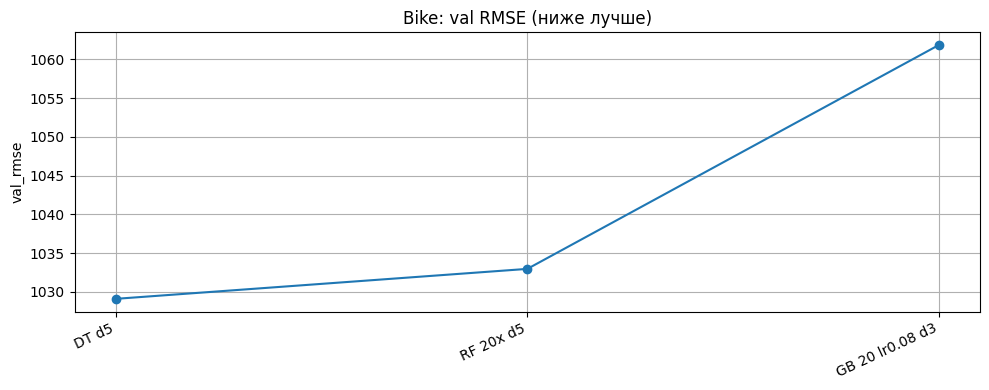

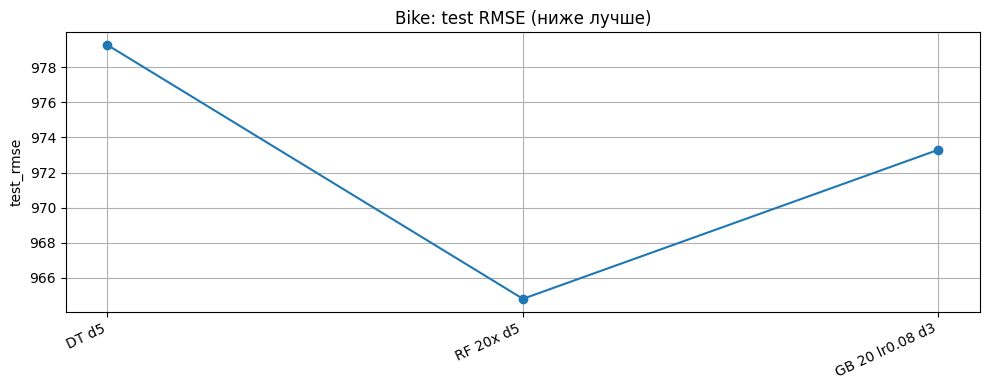

Best (Bike) by val_rmse: {'name': 'DT d5', 'fit_sec': 0.5059835910797119, 'val_rmse': 1029.1102294921875, 'test_rmse': 979.2573852539062, 'test_mae': 664.2799682617188, 'test_r2': 0.11175775527954102}


In [31]:
plot_compare(bike_results, "val_rmse", "Bike: val RMSE (ниже лучше)")
plot_compare(bike_results, "test_rmse", "Bike: test RMSE (ниже лучше)")

best_bike = sorted(bike_results, key=lambda r: r["val_rmse"])[0]
print("Best (Bike) by val_rmse:", best_bike)

### Классификация: CIFAR-10

In [32]:
import os
import pickle
import torch
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
POOL_TIMES = 2  # 0=no pooling, 1=16x16, 2=8x8

def to_pooled_features(X_flat: torch.Tensor, pool_times: int = 2) -> torch.Tensor:
    """
    X_flat: (N, 3072) in [0,1]
    returns: (N, 3*(32/2^t)*(32/2^t))
    """
    x = X_flat.view(-1, 3, 32, 32)
    for _ in range(max(0, pool_times)):
        x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x.flatten(1)

def make_cifar_subsets(Xtr, ytr, Xte, yte, n_train=5000, n_val=5000, n_test=5000, seed=42):
    g = torch.Generator().manual_seed(seed)
    perm = torch.randperm(Xtr.shape[0], generator=g)
    tr_idx = perm[:n_train]
    va_idx = perm[n_train:n_train + n_val]

    te_idx = torch.randperm(Xte.shape[0], generator=g)[:n_test]

    return (Xtr[tr_idx], ytr[tr_idx]), (Xtr[va_idx], ytr[va_idx]), (Xte[te_idx], yte[te_idx])

CIFAR_ROOT = "./cifar-10-batches-py"

Xtr, ytr, Xte, yte = load_cifar10_python(CIFAR_ROOT)
(trX, try_), (vaX, vay_), (teX, tey_) = make_cifar_subsets(Xtr, ytr, Xte, yte, seed=SEED)

trX_d = to_pooled_features(trX.to(DEVICE), POOL_TIMES)
vaX_d = to_pooled_features(vaX.to(DEVICE), POOL_TIMES)
teX_d = to_pooled_features(teX.to(DEVICE), POOL_TIMES)

try_d = try_.to(DEVICE)
vay_d = vay_.to(DEVICE)
tey_d = tey_.to(DEVICE)

print("Train/Val/Test pooled shapes:", trX_d.shape, vaX_d.shape, teX_d.shape)


Train/Val/Test pooled shapes: torch.Size([5000, 192]) torch.Size([5000, 192]) torch.Size([5000, 192])


In [ ]:
cifar_results = []

print("FITTING DT")

cifar_results.append(eval_clf(
    DecisionTree(max_depth=5, min_samples_split=20, min_samples_leaf=10, max_features="sqrt", n_thresholds=16,
                 classification=True, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "DT d5"
))

print("FITTING RF")

cifar_results.append(eval_clf(
    RandomForest(n_estimators=20, max_depth=5, min_samples_split=80, min_samples_leaf=30, max_features="sqrt",
                 n_thresholds=16, bootstrap=True, classification=True, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "RF 140x d18"
))

print("FITTING GB")

cifar_results.append(eval_clf(
    GradientBoosting(n_estimators=5, learning_rate=0.2, max_depth=2, min_samples_split=10, min_samples_leaf=30,
                     max_features="sqrt", n_thresholds=12, classification=True, random_state=SEED, device=DEVICE),
    Xtr_d, ytr_d, Xva_d, yva_d, Xte_d, yte_d, "GB 6 lr0.2 d2"
))

cifar_results


FITTING DT
FITTING RF
FITTING GB


In [ ]:
plot_compare(cifar_results, "val_acc", "CIFAR: val accuracy (выше лучше)")
plot_compare(cifar_results, "test_acc", "CIFAR: test accuracy (выше лучше)")

best_cifar = sorted(cifar_results, key=lambda r: -r["val_acc"])[0]
print("Best (CIFAR) by val_acc:", best_cifar)

## 6) Почему A победил, а B проиграл (кратко)

- **DecisionTree**: одно дерево легко переобучается (высокая variance) -> обычно слабее ансамблей.
- **RandomForest**: усредняет много разных деревьев (bootstrap + случайные признаки) -> variance падает -> качество стабильнее.
- **GradientBoosting**: последовательно исправляет ошибки (снижает bias) -> часто лучший на табличной регрессии.  
  На CIFAR без извлечения признаков (и при raw 3072 пикселях) бустинг может быть невыгоден по времени
  (в мультиклассе это K деревьев на итерацию) и/или переобучаться на шуме пикселей.

## 7) Если не укладывается по времени (1660 Ti)

Только 3 ручки (и всё):
- CIFAR: `N_TRAIN=15000`, `N_VAL=3000`, `N_TEST=3000`
- RF: `n_estimators=60..100`
- GB (CIFAR): `n_estimators=4..8` (мультикласс дорогой)

In [ ]:
1